# Experiment 5: Equilibrium Selection in Coordination Games

**Objective**: Investigate the "Equilibrium Selection" problem (or "Tower of Babel" problem) highlighted in the Pluribus paper.

**Context**: In multiplayer general-sum games, there can be multiple Nash Equilibria. If Agent A plays Strategy 1 (part of Equilibrium 1) and Agent B plays Strategy 2 (part of Equilibrium 2), their joint play might be disastrous, even if both strategies are individually "rational" in their respective contexts.

**The Game**: A 3-Player "Pure Coordination" game.
*   **Players**: 3
*   **Actions**: 3 (A, B, C)
*   **Payoff**: +1 to everyone if all players choose the SAME action. 0 otherwise.
*   **Equilibria**: (A,A,A), (B,B,B), (C,C,C) are all pure Nash Equilibria.

**Experiment**: We train 3 **independent** CFR agents. They don't communicate. Will they converge to the *same* equilibrium (e.g., all A), or will they get stuck in a mixed confusion?

In [1]:
%matplotlib inline
import pyspiel
import numpy as np
import matplotlib.pyplot as plt
from solvers import CFRPlusSolver

print("Setting up Coordination Game...")

# Define Payoff Tensor for 3-Player Coordination Game
# Shape: (3, 3, 3) for 3 actions each
payoffs = np.zeros((3, 3, 3))

# Set diagonal to 1 (Coordination Success)
for i in range(3):
    payoffs[i, i, i] = 1.0

# Create Tensor Game
tensor_game = pyspiel.create_tensor_game([payoffs, payoffs, payoffs])
game = pyspiel.convert_to_turn_based(tensor_game)

print("Game created. Payoffs are 1.0 if all match, 0.0 otherwise.")

Optional module pokerkit_wrapper was not importable: No module named 'pokerkit'
Setting up Coordination Game...
Game created. Payoffs are 1.0 if all match, 0.0 otherwise.


Training CFR+ agents...


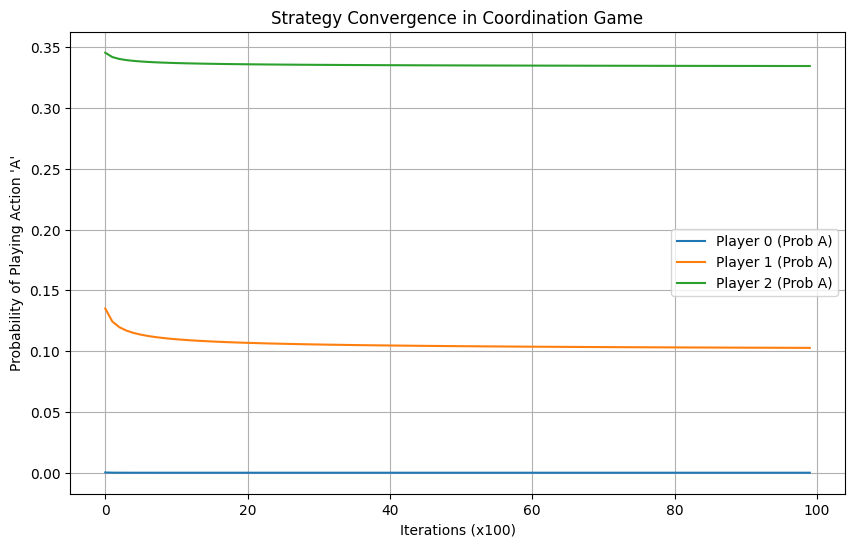

Evaluating Coordination...
Coordination Rate: 13.80%


In [2]:
# Train Independent Agents
# In a real scenario, "independent" means they might have different random seeds or initialization.
# Here, we use a single solver instance which updates all players, but CFR treats them as separate learners minimizing their own regret.
# To truly test selection risk, we should ideally run *multiple runs* and see if they converge to *different* pure strategies,
# OR see if a single run converges to a mixed strategy that fails to coordinate.

print("Training CFR+ agents...")
solver = CFRPlusSolver(game)
iterations = 10000

# We track the probability of playing Action 0 (A) for each player over time
prob_a_history = {0: [], 1: [], 2: []}

for i in range(iterations):
    for player in range(3):
        solver.cfr(game.new_initial_state(), player, i)
    
    if (i + 1) % 100 == 0:
        # Check the strategy at the root node (or first action for each player)
        # Note: In turn-based form, P0 acts first, then P1, then P2.
        # We need to traverse the tree to get P1 and P2's average strategies.
        
        policy = solver.get_policy()
        
        # P0's strategy at root
        state0 = game.new_initial_state()
        probs0 = policy.action_probabilities(state0)
        prob_a_history[0].append(probs0.get(0, 0.0))
        
        # P1's strategy (assuming P0 played 0)
        state1 = state0.child(0)
        probs1 = policy.action_probabilities(state1)
        prob_a_history[1].append(probs1.get(0, 0.0))
        
        # P2's strategy (assuming P0 played 0, P1 played 0)
        state2 = state1.child(0)
        probs2 = policy.action_probabilities(state2)
        prob_a_history[2].append(probs2.get(0, 0.0))

# Plot Prob(Action A) for each player
plt.figure(figsize=(10, 6))
plt.plot(prob_a_history[0], label="Player 0 (Prob A)")
plt.plot(prob_a_history[1], label="Player 1 (Prob A)")
plt.plot(prob_a_history[2], label="Player 2 (Prob A)")
plt.title("Strategy Convergence in Coordination Game")
plt.xlabel("Iterations (x100)")
plt.ylabel("Probability of Playing Action 'A'")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Coordination Rate
print("Evaluating Coordination...")
success_count = 0
num_evals = 1000
policy = solver.get_policy()

for _ in range(num_evals):
    state = game.new_initial_state()
    actions_taken = []
    while not state.is_terminal():
        probs = policy.action_probabilities(state)
        action = np.random.choice(list(probs.keys()), p=list(probs.values()))
        actions_taken.append(action)
        state.apply_action(action)
    
    # Check if all actions are the same
    if len(set(actions_taken)) == 1:
        success_count += 1

coordination_rate = success_count / num_evals
print(f"Coordination Rate: {coordination_rate:.2%}")

## Result Interpretation

1.  **Convergence**: Did the players converge to a pure strategy (e.g., all Prob(A) = 1.0)? Or did they stay mixed (e.g., 33% each)?
2.  **Coordination Failure**: If the Coordination Rate is significantly less than 100%, it proves the risk. For example, if players converge to a mixed strategy (1/3 each), they only coordinate 1/9 of the time (random chance). If they converge to *different* pure strategies (e.g., P0->A, P1->B), the rate is 0%.
3.  **Pluribus Context**: This simple experiment demonstrates why Pluribus could not just rely on independent self-play without mechanisms to ensure consistent strategy selection across the team (or in this case, the single agent playing against copies of itself).